In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 7.1 MB/s 
     |████████████████████████████████| 596 kB 72.9 MB/s 
     |████████████████████████████████| 61 kB 677 kB/s 
     |████████████████████████████████| 3.3 MB 59.3 MB/s 
     |████████████████████████████████| 895 kB 24.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

from transformers import TFBertModel, BertConfig, BertTokenizerFast


In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/CompLit/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CompLit/test.csv")


In [5]:
ex_len = []
for i in train_df['excerpt']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  205 words


In [6]:
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
def encoder(df, tokenizer, label = 'excerpt', maxLen = 205):
    input_id = []
    token_type = []
    attention_mask = []
    for i in df[label].values:
        token = tokenizer(i, max_length = maxLen, truncation = True, padding = 'max_length', add_special_tokens = True)
        input_id.append(token['input_ids'])
        token_type.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    return np.array(input_id), np.array(token_type), np.array(attention_mask)

In [8]:
train_d = encoder(train_df, tokenizer)
test_d = encoder(test_df, tokenizer)

In [9]:
train_d

(array([[  101,  2043,  1996, ...,  2031,  2042,   102],
        [  101,  2035,  2083, ...,  1999,  1012,   102],
        [  101,  2004,  5074, ...,  1998,  2009,   102],
        ...,
        [  101,  1996,  2117, ...,  1997,  1996,   102],
        [  101, 26778,  2024, ...,  5024,  2003,   102],
        [  101,  4176,  2024, ..., 25700,  2079,   102]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]))

In [10]:
test_d

(array([[  101,  2026,  3246, ...,     0,     0,     0],
        [  101, 11089,  3723, ...,  8542,  2009,   102],
        [  101,  2009,  2001, ...,  3328,  2041,   102],
        ...,
        [  101,  2139,  8569, ...,  8569, 12588,   102],
        [  101,  2000,  4863, ...,     0,     0,     0],
        [  101,  6501,  2050, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [11]:
tok = train_d[0].flatten()[:100]

print(train_d[0].shape, '\n')
print('original sequence:')
print(train_df['excerpt'][0].split()[:100], '\n')
print('tokenised sequence:')
print(tokenizer.convert_ids_to_tokens(tok), '\n')
# print(tokenizer.convert_ids_to_tokens(train_d[0].flatten()[0:100]))

(2834, 205) 

original sequence:
['When', 'the', 'young', 'people', 'returned', 'to', 'the', 'ballroom,', 'it', 'presented', 'a', 'decidedly', 'changed', 'appearance.', 'Instead', 'of', 'an', 'interior', 'scene,', 'it', 'was', 'a', 'winter', 'landscape.', 'The', 'floor', 'was', 'covered', 'with', 'snow-white', 'canvas,', 'not', 'laid', 'on', 'smoothly,', 'but', 'rumpled', 'over', 'bumps', 'and', 'hillocks,', 'like', 'a', 'real', 'snow', 'field.', 'The', 'numerous', 'palms', 'and', 'evergreens', 'that', 'had', 'decorated', 'the', 'room,', 'were', 'powdered', 'with', 'flour', 'and', 'strewn', 'with', 'tufts', 'of', 'cotton,', 'like', 'snow.', 'Also', 'diamond', 'dust', 'had', 'been', 'lightly', 'sprinkled', 'on', 'them,', 'and', 'glittering', 'crystal', 'icicles', 'hung', 'from', 'the', 'branches.', 'At', 'each', 'end', 'of', 'the', 'room,', 'on', 'the', 'wall,', 'hung', 'a', 'beautiful', 'bear-skin', 'rug.', 'These'] 

tokenised sequence:
['[CLS]', 'when', 'the', 'young', 'people', 'ret

In [12]:
# config will be downloaded and cached
model_config = BertConfig.from_pretrained(bert_model)

In [13]:
model_config.output_hidden_states = True

In [14]:
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [15]:
# Downloads the model 
bert = TFBertModel.from_pretrained(bert_model, config = model_config)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [16]:
# tunable parameters
max_len = 205
learning_rate = 1e-4
epochs = 8

# callbacks
ckpt_dir = '/content/drive/MyDrive/CompLit/checkpoint/ckpt.h5'

ckpt = ModelCheckpoint(
    filepath = ckpt_dir,
    save_freq = 'epoch',
    save_weights_only=True)

optimizer = Adam(learning_rate = learning_rate)
loss = 'mse'
metrics = [RootMeanSquaredError()]
callbacks=[ckpt]

In [17]:
input_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
token_type_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_type_ids')
attention_mask_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
inputs = [input_ids_i, token_type_ids_i, attention_mask_i]

bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]
output = bert_output[:, 0, :]

output = Dropout(0.1)(output)

output = Dense(32, activation = 'linear')(output)
output = Dense(1, activation = 'linear')(output)

model = Model(inputs = inputs, outputs = output)

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 205)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 205)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 205)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [18]:
print(bert_output.shape)

(None, 205, 768)


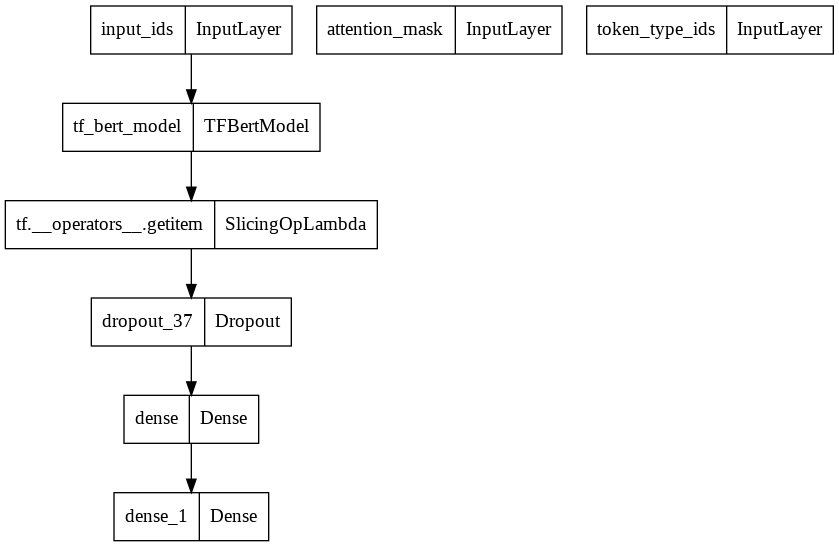

In [19]:
plot_model(model)

In [20]:
train_l = train_df['target'].values

val_prob = 0.1
split = int(len(train_l)*(1 - val_prob))
print(split)
print(2834 - split)
train_x = tuple(np.array(train_d)[:, :split, :])
train_y = train_l[:split]

val_x = tuple(np.array(train_d)[:, split:, :])
val_y = np.array(train_l[split:])
print(val_x[0].shape)
val_y.shape


2550
284
(284, 205)


(284,)

In [21]:
#model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs = epochs, callbacks = callbacks)

In [22]:
#model.save('/content/drive/MyDrive/NLP J Comp/checkpoint/ckpt.h5')

In [23]:
model.load_weights("/content/drive/MyDrive/CompLit/checkpoint/ckpt.h5")


In [24]:
test_output=model.predict(test_d)

In [25]:
def scale(val):
  NewValue = (((val - -3.7) * (4 - 12)) / (1.8 - -3.7)) + 12
  return round(NewValue)

for i in range(0,len(test_df['excerpt'])):
  print(i+1,". ",test_df['excerpt'][i],"\n")
  print("Complexity Score: ",test_output[i][0],"\n")
  print("Standard: ",scale(test_output[i][0]),"\n")

1 .  My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.
"I am certain to go wrong," I said to myself.
"It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning." 

Complexity Score:  -0.12114967 

Standard:  7 

2 .  Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played "Kin

In [26]:
import pandas as pd
  
# initialize list of lists
data = [["Now is the winter of our discontent Made glorious summer by this sun of York; And all the clouds that lour'd upon our house In the deep bosom of the ocean buried. Now are our brows bound with victorious wreaths; Our bruised arms hung up for monuments; Our stern alarums changed to merry meetings, Our dreadful marches to delightful measures."]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['excerpt'])
pred = encoder(df, tokenizer)
pred_output=model.predict(pred)
print(data[0][0],"\n")
print("Complexity Score: ",pred_output,"\n")
print("Standard: ",scale(pred_output[0][0]),"\n")

Now is the winter of our discontent Made glorious summer by this sun of York; And all the clouds that lour'd upon our house In the deep bosom of the ocean buried. Now are our brows bound with victorious wreaths; Our bruised arms hung up for monuments; Our stern alarums changed to merry meetings, Our dreadful marches to delightful measures. 

Complexity Score:  [[-2.500887]] 

Standard:  10 



In [27]:
rmse_df = train_df.iloc[-84:,:]
rmse_test=encoder(rmse_df,tokenizer)
rmse_output=model.predict(rmse_test)
from sklearn.metrics import mean_squared_error
print('RMSE: ',mean_squared_error(rmse_output,rmse_df['target'])**0.5)

RMSE:  0.6128736762276588
